In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline


## Importación Dataset

In [2]:
df = pd.read_csv('properatti.csv', index_col = 0) ### Dataset Completo
## DataFrame Partido en distintas partes relevantes
df_posicion_geografica = df.loc[:,['place_name','state_name','country_name','place_with_parent_names' \
                                   ,'geonames_id','lat','lon','lat-lon', \
                                   'describe','title']] ### Parte con Posición Geográfica
df_localidad=df.loc[:,['place_name','place_with_parent_names','describe','title']] ## Parte con Localidades
df_ambientes = df.loc[:,['rooms','property_type','description','title']]  ## Parte con Ambientes
df_pisos = df.loc[:,['floor','property_type','description','title']]  ## Parte con Pisos
df_precio = df.loc[:,['price','currency','price_aprox_local_currency','price_aprox_usd',\
                      'surface_total_in_m2','surface_covered_in_m2','price_usd_per_m2',\
                      'price_per_m2','description','title']]  ## Parte con Precios y Superficies

C:\Users\zelru\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


## Funciones

In [3]:
def crear_serie_precio(x):
    if not np.isnan(np.array(x.precio_en_titulo)):
        return x.precio_en_titulo
    elif not np.isnan(np.array(x.price_aprox_usd)):
        return x.price_aprox_usd
    else:
        return np.NaN
def crear_serie_ambientes(x):
    if not np.isnan(np.array(x.rooms_description)):
        return x.rooms_description
    if not np.isnan(np.array(x['rooms_title'])):
        return x['rooms_title']
    if not np.isnan(np.array(x.rooms)):
        return x.rooms
    return np.NaN
def detectar_ambientes(x):
    y = busqueda_monoambientes(x)
    if np.isnan(np.array(y)):
        y=busqueda_ambientes(x)
    if np.isnan(np.array(y)):
        y=busqueda_por_texto(x)
    return y
def update(df,column,s):
    '''
    Reemplaza los valores de la columna del DataFrame con
    los valores no nulos de la serie
    '''
    df[column]=s.fillna(df[column])
    return df

def busqueda_ambientes(x):
    '''
    Busca la palabra amb (de ambientes) y devuelve el número que tiene por delante
    '''
    try:
        pattern = '(\d+)\s*amb'
        regex = re.compile(pattern, flags = re.IGNORECASE | re.UNICODE)
        m = regex.search(x)
        if m:
            valor =float(m.group(1))
            if valor < 8:
                return valor
            else:
                return 1.0
        else:
            return np.NaN
    except:
        return np.NaN

def busqueda_monoambientes(x):
    '''
    Busca en la palabra monoambiente y devuelve 1
    '''
    if type(x) is str:
        if x.lower().find('monoambiente') >-1:
            return 1.0
        else:
            return np.NaN
    else:
        return np.NaN
def busqueda_moneda(x):
    try:
        pattern = 'U\$D\s*([\d\.]+)'
        regex = re.compile(pattern, flags = re.IGNORECASE | re.UNICODE)
        m = regex.search(x)
        if m:
            return float(m.group(1).replace('.',''))
        else:
            np.NaN
    except:
        return np.NaN
    
def parsear_numeros(x):
    '''
    Reemplaza numeros escritos en letras por sus equivalentes
    en arábigos.
    '''
    try:
        numeros={'uno':1,'un':1,'una':1,'dos':2,'tres':3,'cuatro':4,'cinco':5,'seis':6,'siete':7,'ocho':8,'nueve':9,'diez':10}
        for key in numeros:
            x = x.lower()
            x=x.replace(key,str(numeros[key]))
        return x
    except:
        return x

def busqueda_por_texto(x):
    '''
    Busca palabras claves asociadas a ambientes, como dormitorio, comedor, living, etc.
    y devuelve el número de veces que estas aparecen.
    '''
    result = 0.0
    valor = 0.0
    try:
        pattern = r"(\d*\s*living\s*cocina\s*comedor|living\s*comedor|living)|(\d*\s*dormitorio)|(\d*\s*comedor)"
        regex = re.compile(pattern, flags = re.IGNORECASE | re.UNICODE)
        grupos = regex.findall(x)
        for grupo in grupos:
            for elemento in grupo:
                regex_dos = re.compile(r'(\d+)', flags = re.IGNORECASE | re.UNICODE)
                cantidad = regex_dos.search(elemento)
                if cantidad is not None:
                    nuevo_valor = float(cantidad.group())
                    if nuevo_valor < 8:
                        valor+=nuevo_valor
            if result == valor:
                result+=1
                valor+=1
            else:
                result=valor
        if result > 0.0:
            return result
        else:
            return np.NaN
    except:
        return np.NaN
def convert_to_int(x):
    return int(x)
def busqueda_moneda(x):
    try:
        pattern = 'U\$D\s*([\d\.]+)'
        regex = re.compile(pattern, flags = re.IGNORECASE | re.UNICODE)
        m = regex.search(x)
        if m:
            return float(m.group(1).replace('.',''))
        else:
            np.NaN
    except:
        return np.NaN

# Parte Ambientes

* Descripción

In [4]:
df_ambientes.isnull().sum()

rooms            73830
property_type        0
description          2
title                0
dtype: int64

* Limpieza de Datos

In [5]:
df_ambientes_limpio = df_ambientes
df_ambientes_limpio.description=df_ambientes_limpio.description.apply(parsear_numeros)## Reemplaza los números escritos en letras por los arábigos
df_ambientes_limpio.title = df_ambientes_limpio.title.apply(parsear_numeros)
df_ambientes_limpio['rooms_title'] = df_ambientes.title.apply(detectar_ambientes)
df_ambientes_limpio['rooms_description'] = df_ambientes.description.apply(detectar_ambientes)
rooms = df_ambientes.apply(crear_serie_ambientes,1)
rooms.isnull().sum()

11782

In [6]:
x=24
df_ambientes.iloc[x,1],df_ambientes.iloc[x,0],df_ambientes.iloc[x,2],df_ambientes.iloc[x,3]## Estado de los Ambientes al presente

('apartment',
 4.0,
 'exclusivo  departamento de excelente categoria en venta en castelar160 mts2  cubiertos.  4 ambientes con balcón terraza, parrilla y cochera. entrega marzo 2018.el precio publicado corresponde al valor de contado  para las 1idades de primer y seg1do piso. financiacion: anticipo usd71.000, usd 105.000 a la escritura y el resto financiado en 36 cuotas (con refuerzos semestrales) valor financiado usd 380.940piso con palier privado con puerta de seguridad  y entrada de servicio. linving comedor , 3 dormitorios 1 de los cuales es en suite  con ducha escocesa, con vestidor. otros 2 dormitorios con placars  que comparten 1 baño completo con bañera.  pisos de madera en dormitorios y living comedor, pisos de porcelanato en pasillos y cocina. ventanas de aluminio con dvh (doble vidrio hermético) en todo el depto. cocina completa (con cocina vitroceramica, horno eléctrico, microondas, heladera con frezzer, cafetera express to2 marca bgh),  despensa y lavadero. toilete, balcón

In [7]:
df_ambientes.iloc[12,2]

'excelente departamento 2 ambientes contrafrente con balcon a pulmon de manzana.a solo media cuadra de la av. santa fe.living                   3,06 x 5,30 dormitorio          2,80 x 3,60     baño                     1,55 x 2,11     cocina                  1,60 x 3,13    balcon                  4,61 x 1 posee 2 aires acondiciona2 nuevos.terraza.total cubiertos: 35,66semi  3,56total: 39,22     aviso publicado por pixel inmobiliario (servicio de páginas web para inmobiliarias).'

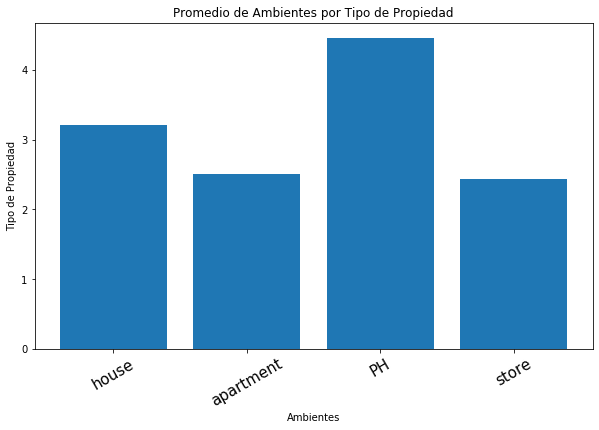

In [17]:

df_ambientes_mean =df_ambientes.groupby('property_type').mean()
property_type = list(set(df_ambientes.property_type))
valores=list(df_ambientes_mean.rooms)

index = np.arange(len(property_type))
plt.figure(figsize=(10,6))
plt.bar(index, valores)
plt.xlabel('rooms', fontsize=10)
plt.ylabel('Tipo de Propiedad', fontsize=10)
plt.xticks(index, property_type, fontsize=15, rotation=30)
plt.title('Promedio de Ambientes por Tipo de Propiedad')
plt.show()

## Hay un problema en la data

#plt.show()

In [18]:
df_ambientes[df_ambientes.rooms >8 ].iloc[0,2]


'corredor responsable: raul lopez - csi 6292contacto: emiliano f1es - mls id # 420791010-1ph 5 dormitorios  excelente ubicación olivos quinta presidencial  tipo de propiedad: ph tipo casa de 3 plantas, 6 dormitorios, 3 baños completos, 1 toilette, lavadero, terraza con parrilla.  descripcion: ph espacioso muy buena distribución y f1cionalidad. buen estado de conservación y luminosidad en to2 sus ambientes. posibilidad de colocar caldera y radiadores para calefacción central (posee todo el sistema de cañerías instala2)  planta baja: sala de estar y living. amplia y cómoda cocina con barra y muebles completos. comedor amplio con salida a patio cerrado que conecta a pasillo de uso común. lavadero separado en aire luz cerrado con policarbonato. baño completo.  pisos de cerámica en toda la planta. muy buen estado de mantenimiento. 2 aires acondiciona2.  planta alta 1: playroom con gran placar no embutido (opción de dormitorio) con salida a balcón a la calle, dormitorio alfombrado (buen esta

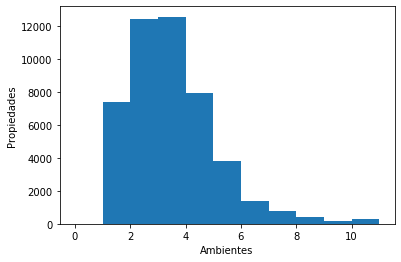

In [19]:
fig, ax = plt.subplots()
ax.hist(df_ambientes.rooms,bins=range(12))
ax.ticklabel_format(useOffset=False, style='plain')
plt.ylabel('Propiedades')
plt.xlabel('rooms')
plt.show()



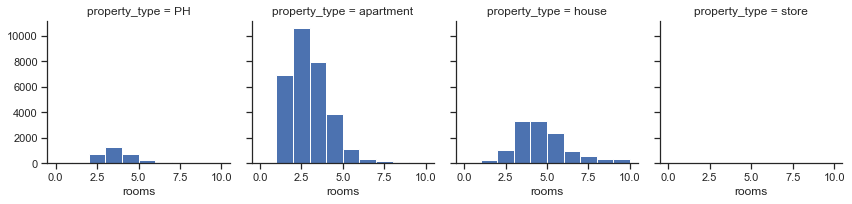

In [20]:
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(df_ambientes, col="property_type")
g = g.map(plt.hist, "rooms",bins=range(11))

# Parte Precios

In [8]:
df_precio.isnull().sum()
## El DataSet nos trae los precios, precios evaluados en ARS y en USD. Usamos los Dolares y nos olvidamos del resto

price                         20410
currency                      20411
price_aprox_local_currency    20410
price_aprox_usd               20410
surface_total_in_m2           39328
surface_covered_in_m2         19907
price_usd_per_m2              52603
price_per_m2                  33562
description                       2
title                             0
dtype: int64

In [9]:
set(df_precio.currency)
##Hay valores en Pesos, en Uruguayos, en Peruanos y en Dólares

{'ARS', 'PEN', 'USD', 'UYU', nan}

In [10]:
df_precio[df_precio.currency =='PEN']
## Los registros que tienen precios en Soles, segun esto pertenece a la Arg

,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,description,title
50387,380000.0,PEN,2066864.90,117139.33,NaN,NaN,NaN,NaN,Ref.: 55:PREVENTA ::: OPORTUNIDAD ::: Dúplex a...,DUPLEX A LA VENTA | Liniers 1200 | Tandil
50388,950000.0,PEN,5167162.35,292848.33,NaN,NaN,NaN,NaN,Ref.: 56Duplex en venta de 1 dormitorio con ap...,DUPLEX A LA VENTA | Liniers 1200 | Tandil


In [11]:
df_precio[df_precio.currency =='UYU']
## Segun la descripcion, este esta en Mendoza.

,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,description,title
107390,650000000.0,UYU,4.054773e+08,22980378.29,NaN,NaN,NaN,NaN,"Casa con Calefacción central, Mendoza, San Roq...",Casa - San Vicente


In [12]:
df_precio['precio_en_titulo'] = df_precio.title.apply(busqueda_moneda)
precio = df_precio.apply(crear_serie_precio,1)

In [13]:
precio.isnull().sum()

17982

In [14]:
df_precio[df_precio.description.str.contains('USD').isnull()]
## Ya tienen el precio, no me interesa mirarlos por dentro

,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,description,title,precio_en_titulo
10664,2350000.0,ARS,2325485.81,131796.64,NaN,NaN,NaN,NaN,NaN,HERMOSO DEPARTAMENTO CON PISCINA Y COCHERA,NaN
96691,98000.0,USD,1729161.00,98000.00,NaN,55.0,NaN,1781.818182,NaN,Departamento - San Fernando,NaN


In [15]:
df_precio.title.str.contains('dolar').isnull().sum()

0

- Los datos sin precios los eliminamos

In [16]:
x=11
df_precio[df_precio.currency.isnull()].iloc[x,-1],df_precio[df_precio.currency.isnull()].iloc[x,-2]

(nan,
 'Rosario - Tucuman 3400 - Venta Dptos 2 Dormitorios en construcción - InmGazze')

# Parte Superficie

- Por una cuestión de tiempo solo invertimos aquellos casos donde la superficie cubierta era mayor que la total, debería hacerce una busqueda en description o en title en aquellos casos que estén vacíos.

In [43]:
A = df_precio.apply(lambda x: pd.Series([x.surface_covered_in_m2,x.surface_total_in_m2]) 
                       if x.surface_covered_in_m2 <= x.surface_total_in_m2
                       else pd.Series([x.surface_total_in_m2,x.surface_covered_in_m2]) ,1)

In [51]:
A = df_precio.apply(lambda x: pd.Series([x.surface_covered_in_m2,x.surface_covered_in_m2])
                       if x.surface_covered_in_m2 is None and x.surface_total_in_m2 is not None
                       else (pd.Series([x.surface_total_in_m2,x.surface_total_in_m2])
                       if x.surface_covered_in_m2 is not None and x.surface_total_in_m2 is None
                       else pd.Series([x.surface_covered_in_m2,x.surface_total_in_m2])) ,1)

In [56]:
A[A.iloc[:,1].isnull()]

,0,1
1,NaN,NaN
3,NaN,NaN
9,NaN,NaN
11,NaN,NaN
65,NaN,NaN
68,72.0,NaN
70,NaN,NaN
71,NaN,NaN
72,NaN,NaN
77,85.0,NaN


# Parte Posición Geográfica

In [21]:
df_localidad_ex = pd.DataFrame(item for item in df_posicion_geografica.place_with_parent_names.str.split('|'))
df_localidad_ex.isnull().sum()
##Las variables de "zona" 4,5 y 6 estan muy incompletas. la mas recuperable es la 4
#df_posicion_geografica['pais_ex'] = df_localidad_ex[1]
#df_posicion_geografica['provincia_ex'] = df_localidad_ex[2]
#df_posicion_geografica['localidad_ex'] = df_localidad_ex[3]
#df_posicion_geografica['barrio_ex'] = df_localidad_ex[4]
#df_posicion_geografica['zona_ex'] = df_localidad_ex[5]

0         0
1         0
2         0
3         0
4      4780
5     80780
6    120672
dtype: int64

In [22]:
set(df_localidad_ex[1]) #Categorias de pais

{'Argentina'}

In [23]:
set(df_localidad_ex[2]) #Categoria de provincia, BSAS esta dividida en 5 partes

{'Bs.As. G.B.A. Zona Norte',
 'Bs.As. G.B.A. Zona Oeste',
 'Bs.As. G.B.A. Zona Sur',
 'Buenos Aires Costa Atlántica',
 'Buenos Aires Interior',
 'Capital Federal',
 'Catamarca',
 'Chaco',
 'Chubut',
 'Corrientes',
 'Córdoba',
 'Entre Ríos',
 'Formosa',
 'Jujuy',
 'La Pampa',
 'La Rioja',
 'Mendoza',
 'Misiones',
 'Neuquén',
 'Río Negro',
 'Salta',
 'San Juan',
 'San Luis',
 'Santa Cruz',
 'Santa Fe',
 'Santiago Del Estero',
 'Tierra Del Fuego',
 'Tucumán'}

In [24]:
set(df_localidad_ex[3]) #Localidad

{'',
 'Abasto',
 'Achiras',
 'Adolfo Alsina',
 'Agronomía',
 'Agua Blanca',
 'Agua de Oro',
 'Aguas Verdes',
 'Aldea Brasilera',
 'Aldea Salto',
 'Alejandro Roca',
 'Almafuerte',
 'Almagro',
 'Almirante Brown',
 'Alta Gracia',
 'Aluminé',
 'Alvear',
 'Anisacate',
 'Apóstoles',
 'Arequito',
 'Arocena',
 'Arroyo Ceibal',
 'Arroyo Leyes',
 'Arroyo Seco',
 'Ascochinga',
 'Ataliva',
 'Avellaneda',
 'Azara',
 'Azul',
 'Bahía Blanca',
 'Balcarce',
 'Balnearia',
 'Balvanera',
 'Banda del Río Salí',
 'Baradero',
 'Barracas',
 'Barranqueras',
 'Barrio Norte',
 'Belgrano',
 'Bell Ville',
 'Bella Italia',
 'Bella Vista',
 'Berazategui',
 'Berisso',
 'Bernardo de Irigoyen',
 'Bialet Massé',
 'Boca',
 'Boedo',
 'Bouwer',
 'Brandsen',
 'Buena Nueva',
 'Cabalango',
 'Caballito',
 'Cafayate',
 'Caleta Olivia',
 'Calmayo',
 'Camet',
 'Campana',
 'Campo Grande',
 'Campo Quijano',
 'Candelaria',
 'Capilla del Monte',
 'Capilla del Rosario',
 'Capitán Bermúdez',
 'Capitán Sarmiento',
 'Cariló',
 'Carlos Ca

In [25]:
set(df_localidad_ex[4]) #Zona

{'',
 ' Country Maschwitz Club',
 ' los alamos',
 '9 de Abril',
 'Abasto',
 'Abril Club de Campo',
 'Acacias Blancas',
 'Acassuso',
 'Adrogué',
 'Aeropuerto Internacional Ezeiza',
 'Albanueva Barrio Cerrado',
 'Aldo Bonzi',
 'Alejandro Korn',
 'Alem',
 'Alfar',
 'Altamira',
 'Alto Los Cardales',
 'Altos de Hudson I',
 'Altos de Hudson II',
 'Altos de Manzanares 1 y 2',
 'Altos de Matheu',
 'Altos del Golf',
 'Altos del Pilar',
 'Armenia Country Club',
 'Arturo Seguí',
 'Avellaneda',
 'Azul',
 'Bahía del Sol',
 'Balcarce',
 'Balneario San Cayetano',
 'Banfield',
 'Barbarita, Barrio Cerrado',
 'Barrancas de San Jose',
 'Barrancas de Santa María',
 'Barrio Acacias',
 'Barrio Alamo Alto',
 'Barrio Alto Camet',
 'Barrio Araucarias',
 'Barrio Camet',
 'Barrio Ceibos',
 'Barrio Cerrado',
 'Barrio Cerrado "Ayres Plaza"',
 'Barrio Cerrado "Buenos Aires Village"',
 'Barrio Cerrado "El Aromo"',
 'Barrio Cerrado "El Casco de Moreno"',
 'Barrio Cerrado "El Estribo"',
 'Barrio Cerrado "Isla del Sol"

In [26]:
set(df_localidad_ex[5])

{'',
 'Barrio Barrancas del Lago',
 'Barrio Cabos del Lago',
 'Barrio El Golf',
 'Barrio El Yacht',
 'Barrio La Alameda',
 'Barrio La Isla',
 'Barrio Las Glorietas',
 'Barrio Los Alisos',
 'Barrio Los Castores',
 'Barrio Los Lagos',
 'Barrio Los Sauces',
 'Barrio Los Tilos',
 'BarrioPortezuelo',
 'Enyoi',
 'Islas del Canal',
 None,
 'QBay Yacht'}

In [27]:
set(df_localidad_ex[6]) #datos vacios

{'', None}

In [28]:
df_localidad_ex[df_localidad_ex[4] =='coordenadas 34.255511'] 
df_localidad_ex.iloc[7367,4] ='Nordelta'
## El registro 7367 es el unico que tiene este campo y esta en Nordelta segun Properatti

In [29]:
print('Vacios: ',len(df_localidad_ex[(df_localidad_ex[4] == '') | (df_localidad_ex[4].isnull())][4]))
print('Con datos:',len(df_localidad_ex)-len(df_localidad_ex[(df_localidad_ex[4] == '') | (df_localidad_ex[4].isnull())][4]))

## Hay 80803 vacios, lo mas facil seria tirarlo, lo ideal seria buscar por la lat/lon de donde viene realmente, pero no tenemos
## datos para todos ni el tiempo para hacerlo, en vez de eso lo que hacemos es pegarle a los vacios y los nulos el dato de
## la localidad, que sigue un criterio parecido al que tiene el dataset

Vacios:  80803
Con datos: 40417


In [30]:
df_posicion_geografica['pais_ex'] = df_localidad_ex[1]
df_posicion_geografica['provincia_ex'] = df_localidad_ex[2]
df_posicion_geografica['localidad_ex'] = df_localidad_ex[3]
df_posicion_geografica['barrio_ex'] = df_localidad_ex[4]

In [31]:
df_posicion_geografica.place_name.fillna(df_posicion_geografica.localidad_ex,inplace=True)

In [32]:
df_posicion_geografica[df_posicion_geografica.place_name !=df_posicion_geografica.localidad_ex].head()
##Hay muchas areas en las que no coinciden el place name con la localidad a la que encontramos que pertenece
##En muchos casos coinciden con algun barrio/zona del daaset

,place_name,state_name,country_name,place_with_parent_names,geonames_id,lat,lon,lat-lon,describe,title,pais_ex,provincia_ex,localidad_ex,barrio_ex
4,Centro,Buenos Aires Costa Atlántica,Argentina,|Argentina|Buenos Aires Costa Atlántica|Mar de...,3435548.0,-38.002626,-57.549447,"-38.0026256,-57.5494468",NaN,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,Centro
6,Munro,Bs.As. G.B.A. Zona Norte,Argentina,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,3430511.0,-34.532957,-58.521782,"-34.5329567,-58.5217825",NaN,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,...",Argentina,Bs.As. G.B.A. Zona Norte,Vicente López,Munro
12,Martínez,Bs.As. G.B.A. Zona Norte,Argentina,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,3430813.0,-34.486019,-58.503814,"-34.4860195,-58.5038139",NaN,EXCELENTE DEPARTAMENTO 2 AMBIENTES CONTRAFRENT...,Argentina,Bs.As. G.B.A. Zona Norte,San Isidro,Martínez
13,Palermo Soho,Capital Federal,Argentina,|Argentina|Capital Federal|Palermo|Palermo Soho|,3430234.0,NaN,NaN,NaN,NaN,Vitraux Palermo,Argentina,Capital Federal,Palermo,Palermo Soho
14,Palermo Soho,Capital Federal,Argentina,|Argentina|Capital Federal|Palermo|Palermo Soho|,3430234.0,NaN,NaN,NaN,NaN,Vitraux Palermo,Argentina,Capital Federal,Palermo,Palermo Soho


In [33]:
len(df_posicion_geografica[df_posicion_geografica.place_name !=df_posicion_geografica.localidad_ex])
#Hay 35170 datos que no coinciden

35170

In [34]:
df_posicion_geografica.barrio_ex =df_posicion_geografica.apply(lambda x: x.localidad_ex 
                                       if x.barrio_ex == '' or x.barrio_ex ==None 
                                       else x.barrio_ex,1)

In [35]:
df_posicion_geografica[df_posicion_geografica.barrio_ex == ''].title.iloc[0]

'Casa 180m² con 2 Plantas en Navarro, Julián 2900, Argentina, Capital Federal, por U$S 170.000'